<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Сначала загрузим необходимые библиотеки.

In [1]:
pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [42]:
#pandas для работы с датафреймами
import pandas as pd
#математические библиотеки
import math
import numpy as np
#графики
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
#sklearn
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error,
    make_scorer
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
#lgmb
from lightgbm import LGBMRegressor
# регулярные выражения
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

## Подготовка

Загрузим данные.

In [3]:
data = pd.read_csv('/datasets/taxi.csv')
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Рассмотрим типы столбцов.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Тип столбца с датой и временем object, преобразуем его.

In [5]:
data['datetime'] = data['datetime'].astype('datetime64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Установиим дату как индекс.

In [6]:
data = data.set_index('datetime')
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Ресемплируем данные по одному часу.

In [7]:
data_resampled = data.resample('1H').sum()
data_resampled

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

Построим график временного ряда со скользящим среднем в две недели.

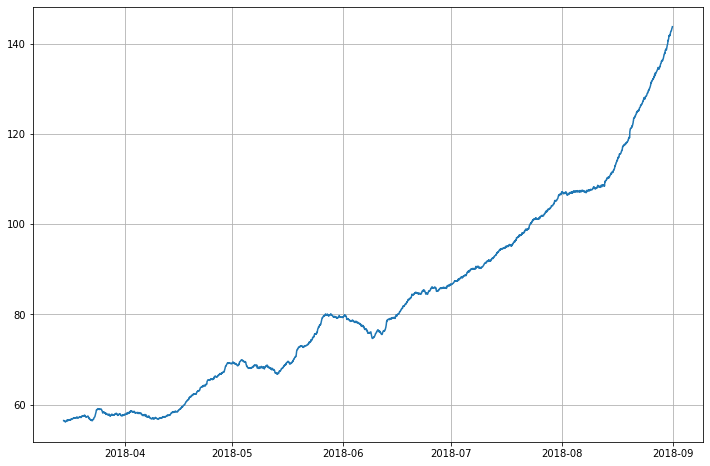

In [8]:
plt.figure(figsize=(12, 8))
#ax = data.rolling(24*7*2).mean().plot()
plt.plot(data_resampled.rolling(24*7*2).mean())
plt.grid()
#ax.set_xlabel('Месяц');

График похож на параболу или экспоненту, на глаз определить сложно. Это можно учесть при составлении модели машинного обучения используя в качестве модели метод опорных векторов и в качестве ядра полином второй степени или экспоненту.

Найдём треды и сезонность с помощью функции seasonal_decompose.

In [9]:
decomposed = seasonal_decompose(data_resampled)

Посмотрим треды

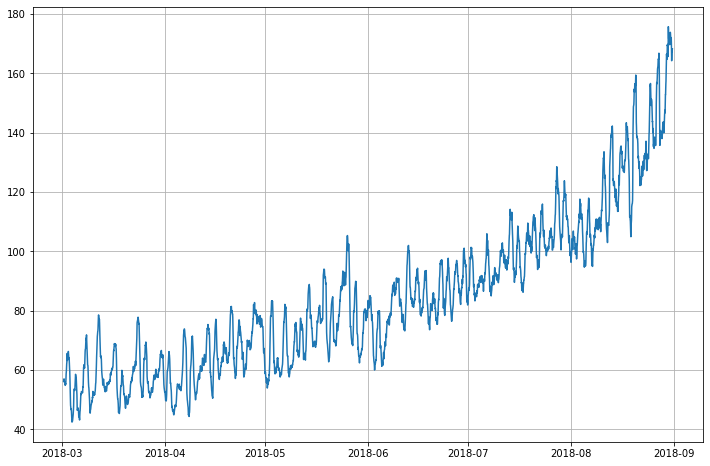

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(decomposed.trend)
plt.grid()

За март тренд не увеличился, однако потом тренд начинает возрастать. 

Посмотрим сезонность за сутки.

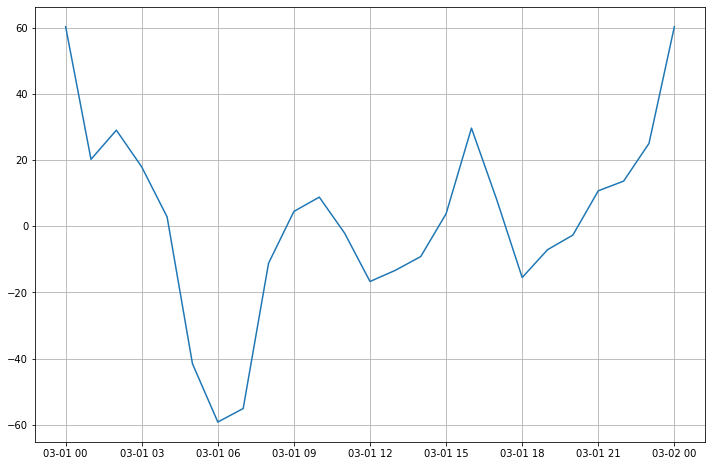

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(decomposed.seasonal['2018-03-01 00:00:00':'2018-03-02 00:00:00'])
plt.grid()

В полночь заказов больше всего, после чего сезонность убывает до 6 утра, в 6 утра наблюдается минимум. Далее сезонность возрастает, с 9 утра до 9 вечера сезонность изменяется незначительно, после чего возрастает. 

Посмотрим сезонность за неделю, для чего ресемплируем данные.

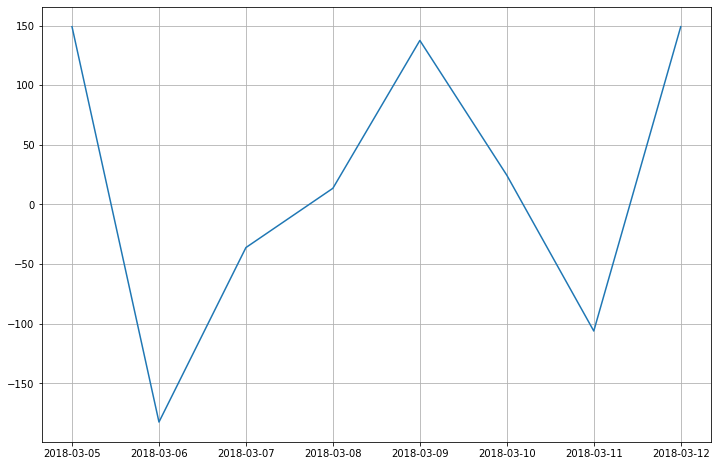

In [33]:
data_resampled_week = data.resample('1D').sum()
decomposed_week = seasonal_decompose(data_resampled_week)

plt.figure(figsize=(12, 8))
plt.plot(decomposed_week.seasonal['2018-03-05':'2018-03-12'])
plt.grid()

Больше всего заказов в понедельник, затем график опускается до вторника, где наблюдается минимум. Со вторника до пятницы количество заказов возрастает, далее убывает до воскресенья.

Рассмотрим остатки.

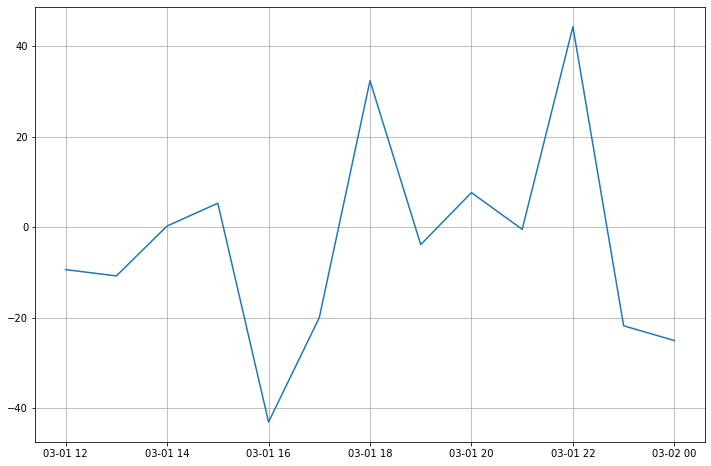

In [62]:
plt.figure(figsize=(12, 8))
plt.plot(decomposed.resid['2018-03-01 00:00:00':'2018-03-02 00:00:00'])
plt.grid()

## Обучение

Сезонность изменяется за часы и недели, тренд изменяется по месяцам. На основе этого добавим в датафрейм столбцы час, день, день недели и месяц.

In [34]:
data_resampled['month'] = data_resampled.index.month
data_resampled['day'] = data_resampled.index.day
data_resampled['dayofweek'] = data_resampled.index.dayofweek
data_resampled['hour'] = data_resampled.index.hour
data_resampled.head()

,num_orders,month,day,dayofweek,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4


Добавим лаги для часа, дня и недели.

In [35]:
for lag in [1, 24, 24*7]:
    data_resampled['lag_{}'.format(lag)] = data_resampled['num_orders'].shift(lag)

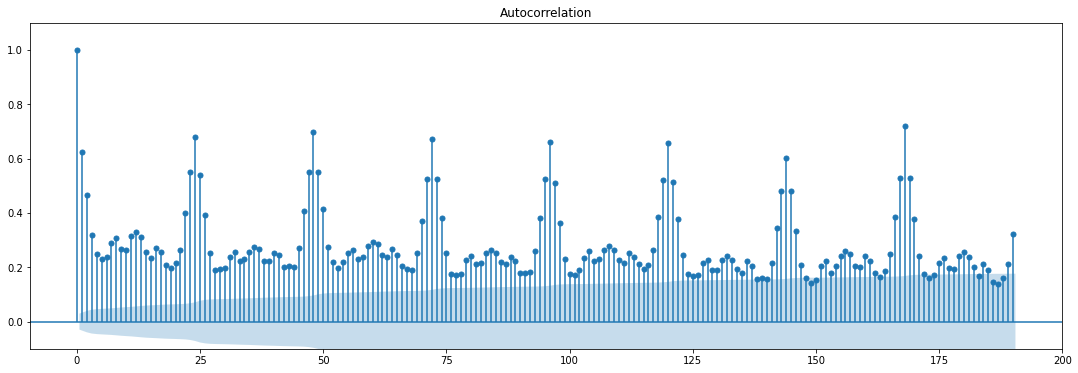

In [36]:
# Код ревьюера
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Разделим данные на тренировочную и тестовую выборки.

In [37]:
train, test = train_test_split(
    data_resampled,
    test_size=0.1,
    shuffle=False)
train.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_24,lag_168
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,NaN,NaN


Уберём пропуски в train.

In [65]:
train = train.dropna()
train

,num_orders,month,day,dayofweek,hour,lag_1,lag_24,lag_168
datetime,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,0,94.0,100.0,124.0
2018-03-08 01:00:00,78,3,8,3,1,143.0,121.0,85.0
2018-03-08 02:00:00,65,3,8,3,2,78.0,24.0,71.0
2018-03-08 03:00:00,68,3,8,3,3,65.0,66.0,66.0
2018-03-08 04:00:00,60,3,8,3,4,68.0,73.0,43.0
...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,8,13,0,9,91.0,108.0,136.0
2018-08-13 10:00:00,156,8,13,0,10,137.0,108.0,124.0
2018-08-13 11:00:00,144,8,13,0,11,156.0,81.0,131.0


Выделим входные и целевые признаки.

In [69]:
X_train = train.drop('num_orders', axis=1)
X_test = test.drop('num_orders', axis=1)
y_train = train['num_orders']
y_test = test['num_orders']

Создадим пайплайны для различных моделей.

Начнём с DecisionTreeRegressor.

In [40]:
param_grid_tree = [
    {
        'min_samples_split': range(2, 10),
        'min_samples_leaf': range(1, 10)
    }
]

In [43]:
tscv = TimeSeriesSplit(n_splits=5)

gs_tree = GridSearchCV(
    estimator=DecisionTreeRegressor(),
    param_grid=param_grid_tree,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    error_score='raise'
)

In [44]:
gs_tree.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise', estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid=[{'min_samples_leaf': range(1, 10),
                          'min_samples_split': range(2, 10)}],
             scoring='neg_root_mean_squared_error')

In [45]:
gs_tree.best_params_

{'min_samples_leaf': 9, 'min_samples_split': 6}

Найдём метрику на валидационной выборке.

In [46]:
gs_tree.best_score_

-26.356508238467335

Попробуем SVR.

In [47]:
param_grid_svr = [
    {
        'kernel': ['linear', 'poly', 'rbf'],
        'degree': [2, 3, 4]
    }
]

In [49]:
gs_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid_svr,
    n_jobs=-1,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    verbose=10
)

In [50]:
gs_svr.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START degree=2, kernel=linear.....................................
[CV 1/5; 1/9] END ...................degree=2, kernel=linear; total time=   0.3s
[CV 2/5; 1/9] START degree=2, kernel=linear.....................................
[CV 2/5; 1/9] END ...................degree=2, kernel=linear; total time=   0.9s
[CV 3/5; 1/9] START degree=2, kernel=linear.....................................
[CV 3/5; 1/9] END ...................degree=2, kernel=linear; total time=   1.9s
[CV 4/5; 1/9] START degree=2, kernel=linear.....................................
[CV 4/5; 1/9] END ...................degree=2, kernel=linear; total time=   3.8s
[CV 5/5; 1/9] START degree=2, kernel=linear.....................................
[CV 5/5; 1/9] END ...................degree=2, kernel=linear; total time=   5.8s
[CV 1/5; 2/9] START degree=2, kernel=poly.......................................
[CV 1/5; 2/9] END .....................degree=2, 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             error_score='raise', estimator=SVR(), n_jobs=-1,
             param_grid=[{'degree': [2, 3, 4],
                          'kernel': ['linear', 'poly', 'rbf']}],
             scoring='neg_root_mean_squared_error', verbose=10)

Найдём метрику на валидационной выборке.

In [51]:
gs_svr.best_score_

-23.51354210462552

Посмотрим какое ядро у лучшей модели.

In [52]:
gs_svr.best_params_

{'degree': 2, 'kernel': 'linear'}

У лучшей модели оказалось линейное ядро.

Модель SVR показала лучшую метрику, будем её использовать на тестовой выборке.

In [53]:
model = gs_svr.best_estimator_

## Тестирование

Найдём метрику RMSE на тестовой выборке.

In [70]:
predict = model.predict(X_test)

In [71]:
mean_squared_error(y_test, predict, squared=False)

36.18449734634172

Построим график временного ряда чтобы оценить качество модели, однако теперь в качестве скользящего среднего возьмём одни сутки.

In [72]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,num_orders
datetime,
2018-08-13 14:00:00,102
2018-08-13 15:00:00,175
2018-08-13 16:00:00,144
2018-08-13 17:00:00,152
2018-08-13 18:00:00,104


In [73]:
y_test_df['num_orders_pred'] = predict
y_test_df.head()

,num_orders,num_orders_pred
datetime,,
2018-08-13 14:00:00,102,104.628201
2018-08-13 15:00:00,175,123.269269
2018-08-13 16:00:00,144,182.423953
2018-08-13 17:00:00,152,130.324569
2018-08-13 18:00:00,104,96.293273


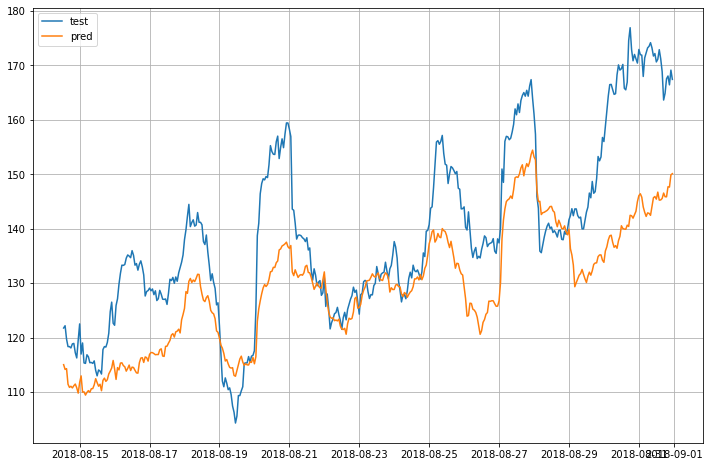

In [74]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_df.rolling(24).mean())
plt.grid()
plt.legend(('test', 'pred'));

Виднеютстя небольшие различия, чтобы узнать на каких данных модель ошибается сильнее выделим графики тренда и сезонности.

In [78]:
decomposed_test = seasonal_decompose(y_test_df['num_orders'])
decomposed_pred = seasonal_decompose(y_test_df['num_orders_pred'])

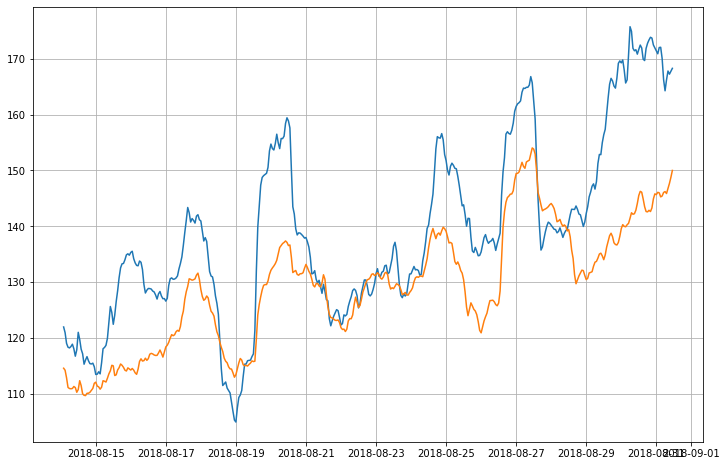

In [79]:
plt.figure(figsize=(12, 8))
plt.plot(decomposed_test.trend)
plt.plot(decomposed_pred.trend)
plt.grid()

Модель не везде учитывает колебания тренда.

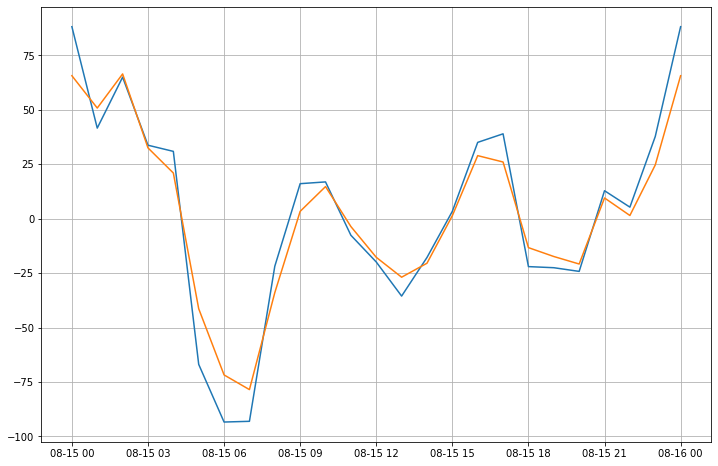

In [77]:
plt.figure(figsize=(12, 8))
plt.plot(decomposed_test.seasonal['2018-08-15 00:00:00':'2018-08-16 00:00:00'])
plt.plot(decomposed_pred.seasonal['2018-08-15 00:00:00':'2018-08-16 00:00:00'])
plt.grid()

Модель хорошо предсказывает колебания по часам.